# Пример расчёта НТД (шаг 1, работа с графиками)

In [1]:
import pandas as pd
#Чтение данных
qт_I = pd.read_excel('DataT110.xlsx',sheet_name='qт_I')
qт_I


,Рнто,Qт,Nт,qт
0,0.5,60,38.3607,1911.4286
1,0.5,70,39.0164,1734.2857
2,0.5,50,40.1639,2094.2857
3,0.5,40,41.3115,2265.7143
4,0.5,60,41.3115,1925.7143
...,...,...,...,...
702,2.0,40,104.3400,2477.5908
703,2.0,30,105.5948,2536.2135
704,2.0,20,106.6877,2591.3395
705,2.0,10,107.9829,2654.6418


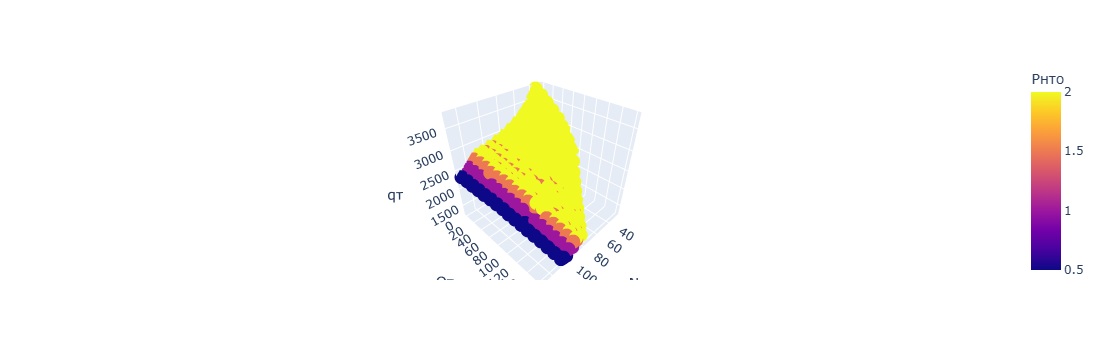

In [3]:
# Визаулизация данных
import plotly.express as px
fig = px.scatter_3d(qт_I , x='Nт', y='Qт', z='qт',
              color='Рнто',opacity=1 ,hover_name='qт')
fig.show()


In [4]:
# Функция аппроксимации
from scipy.interpolate import interp1d, LinearNDInterpolator
def add_curve(Curves,Name,X,F):
        n=np.shape(X);
        if len(n)==1:
            Curves.update({Name:interp1d(X,F,bounds_error=False, fill_value='extrapolate')})
        else:
            Curves.update({Name:LinearNDInterpolator(X, F,rescale=True)})      
        return Curves

# Форсирование расчётной характеристики
1. Необходимо загрузить характеристические поверхности, на основании которых считаются режимы
2. Определить набор уравнений
3. Сформировать множество точек в пространстве

    * N - Мощность от Nmin до Nmax с заданным шагом
    
    * Qт - Величинга теплового отбора от минимума до максимума с заданным шагом ,
    
    * Tc - Температура сетевой воды на входе в подогреватель,
    
    * Gd  - Расход сетевой воды на входе в подогреватель
    
    
4. Посчитать D0 и Q0


In [5]:
import numpy as np
N = np.linspace(20, 121, 11) # от 20 до 120 Мвт , делим два интервал на 11 точек
N = np.arange(20,121,10)     # формируем интервал от 20 до 120 МВт с шагом 10
Gd = np.arange(1000, 4501, 500)
Qт = np.arange(0, 181, 30)
Tr = np.arange(40, 111, 10)
dT = 2.6 #Величина недогрева
out5 = np.meshgrid( Gd, Qт, Tr, dT, N)
d5 = {  "Gd": out5[0].ravel(), "Qт":out5[1].ravel(), "Tr":out5[2].ravel(), "dT":out5[3].ravel(), "N":out5[4].ravel()}
df5 = pd.DataFrame(d5) # 5544
df5

,Gd,Qт,Tr,dT,N
0,1000,0,40,2.6,20
1,1000,0,40,2.6,30
2,1000,0,40,2.6,40
3,1000,0,40,2.6,50
4,1000,0,40,2.6,60
...,...,...,...,...,...
4923,4500,180,110,2.6,80
4924,4500,180,110,2.6,90
4925,4500,180,110,2.6,100
4926,4500,180,110,2.6,110


##  2 Уравнения расчёта

Температура на выходе из теплового подогревателя
1. T1=Tc+Ql/Gd*1000 

Параметр недогрева

2. dt=2.6              

Давление насыщения в отборе

3. Pl_II=Ps(Tc+dt)+0.05          

Удельный расход условного топлива

4. qn_II=qn_II(Pl_II,Ql,N)  

Теповой расход

5. Q0=Qт+qn_II.*N/1000      

Интальпия питательной воды

6. ifw=ifw(D0_II)           

Расход пара в тоннах

7. D0 = Q0./(820-ifw)*1000 

In [6]:
df5['Td_i']=df5['Qт']/df5['Gd']*1000 + df5['Tr']
df5['T_s']=df5['dT']+df5['Td_i']
df5['Ps']= 5.23027171e-04*df5['T_s']**2-6.51769773e-02*df5['T_s']+3.3033

In [7]:
qт_I.keys()

Index(['Рнто', 'Qт', 'Nт', 'qт'], dtype='object')

In [8]:
b={}
b=add_curve(b,'qn',qт_I[['Рнто','Qт','Nт']],qт_I[['qт']])
df5['q']=b['qn'](df5['Ps'],df5['Qт'],df5['N'])
# удаляем точки, не попавшие в область определения поверхности
df5.dropna() # Удадение NAN

,Gd,Qт,Tr,dT,N,Td_i,T_s,Ps,q
2,1000,0,40,2.6,40,40.000000,42.600000,1.475930,3380.181369
3,1000,0,40,2.6,50,40.000000,42.600000,1.475930,3162.077858
4,1000,0,40,2.6,60,40.000000,42.600000,1.475930,3009.409019
5,1000,0,40,2.6,70,40.000000,42.600000,1.475930,2898.702836
6,1000,0,40,2.6,80,40.000000,42.600000,1.475930,2811.417674
...,...,...,...,...,...,...,...,...,...
4143,4500,150,40,2.6,90,73.333333,75.933333,1.369902,1577.005472
4153,4500,150,50,2.6,80,83.333333,85.933333,1.564739,1552.705735
4154,4500,150,50,2.6,90,83.333333,85.933333,1.564739,1625.697716
4164,4500,150,60,2.6,80,93.333333,95.933333,1.864181,1604.307019


In [10]:
df5['Q0']=df5['q']*df5['N']/1000
df5['D0_1']=df5['Q0']/(820-220)*1000
df5['i_pv_1']=-0.000379*df5['D0_1']*df5['D0_1']+0.4125*df5['D0_1']+129.5
df5['D0_2']=df5['Q0']/(820-df5['i_pv_1'])*1000
df5['i_pv_2']=-0.000379*df5['D0_2']*df5['D0_2']+0.4125*df5['D0_2']+129.5
df5['D0_3']=df5['Q0']/(820-df5['i_pv_2'])*1000

In [11]:
df5['Ps'].unique()

array([ 1.47592956,  1.32208165,  1.27283918,  1.32820214,  1.48817054,
        1.75274437,  2.12192363,  2.59570833,  3.17409846,  3.85709403,
        4.64469503,  1.28438473,  1.28744498,  1.39511066,  1.60738177,
        1.92425832,  2.3457403 ,  2.87182772,  3.50252057,  1.30386472,
        1.27554334,  1.35182738,  1.53271687,  1.81821179,  2.20831214,
        2.70301792,  3.30232914,  1.33765551,  1.2734694 ,  1.31388873,
        1.45891349,  1.70854369,  2.06277932,  2.52162039,  3.08506689,
        1.35073687,  1.27534304,  1.30455464,  1.43837168,  1.67679415,
        2.01982206,  2.4674554 ,  3.01969417,  1.36174146,  1.27763051,
        1.29812499,  1.42322491,  1.65293026,  1.98724105,  2.42615727,
        2.96967893,  5.53690147,  6.53371334,  7.63513064,  1.28243171,
        1.37963685,  1.58144742,  1.88786342,  2.29888486,  2.81451173,
        3.43474404,  4.15958178,  1.27623443,  1.30171013,  1.43179126,
        1.66647782,  2.00576982,  2.44966725,  2.99817012,  3.65

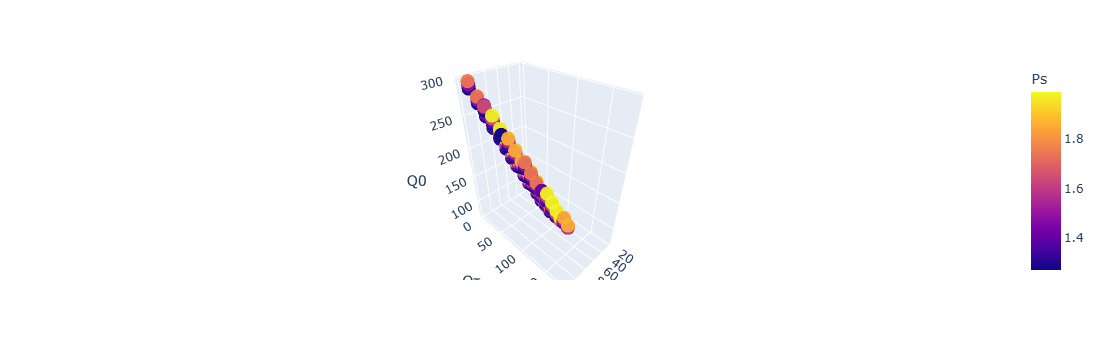

In [12]:
# Визаулизация данных
import plotly.express as px
fig = px.scatter_3d(df5[df5['Ps']<2] , x='N', y='Qт', z='Q0',
              color='Ps',opacity=0.9 )
fig.show()

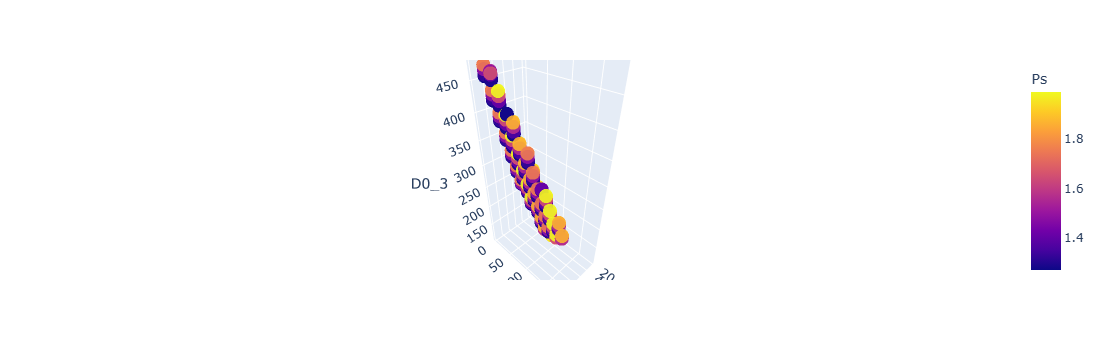

In [13]:
# Визаулизация данных
import plotly.express as px
fig = px.scatter_3d(df5[df5['Ps']<2] , x='N', y='Qт', z='D0_3',
              color='Ps',opacity=0.9 )
fig.show()

In [14]:
Tdata=df5[['D0_1','N','Gd','Qт']]

In [15]:
Tdata.values[:,[1,2,3]]

array([[  20., 1000.,    0.],
       [  30., 1000.,    0.],
       [  40., 1000.,    0.],
       ...,
       [ 100., 4500.,  180.],
       [ 110., 4500.,  180.],
       [ 120., 4500.,  180.]])

In [16]:
from sklearn.linear_model import LinearRegression
def Data_Fit(Tdata):
    ks=Tdata.keys()
    print(ks)
    Values = Tdata.values
    ValsX = Values[:,1:]
    ValsF = Values[:,0]

    lm = LinearRegression()
    lm.fit(ValsX,ValsF)
    print('коеффициенты',lm.coef_)
    print('intercept',lm.intercept_)
    Tdata['fit']=lm.predict(ValsX)
    Tdata['Error+2']=Tdata[ks[0]]-Tdata['fit']
    sigma=Tdata['Error+2'].std()
    Tdata['2sigma+']=2*sigma
    Tdata['2sigma-']=-2*sigma
    print('сигма:',sigma)
    Tdata[['fit',ks[0],'Error+2','2sigma+','2sigma-']].plot(figsize=(12,5))
    Tdata2=Tdata[np.abs(Tdata[ks[0]]-Tdata['fit'])<2*sigma]
    filt_=np.abs(Tdata[ks[0]]-Tdata['fit'])<2*sigma
    return Tdata['fit'],Tdata2,filt_

Index(['D0_3', 'N', 'Qт', 'Ps'], dtype='object')
коеффициенты [ 3.9873995  -1.23913947 31.90338294]
intercept 14.37696272409147
сигма: 1.5304934854171854


(2       220.960089
 3       260.834084
 4       300.708079
 5       340.582074
 6       380.456069
            ...    
 4143    231.076509
 4153    197.418470
 4154    237.292465
 4164    206.971692
 4165    246.845687
 Name: fit, Length: 1059, dtype: float64,
             D0_3   N   Qт        Ps         fit   Error+2   2sigma+   2sigma-
 2     218.680142  40    0  1.475930  220.960089 -2.279947  3.060987 -3.060987
 3     259.666471  50    0  1.475930  260.834084 -1.167613  3.060987 -3.060987
 4     300.565392  60    0  1.475930  300.708079 -0.142686  3.060987 -3.060987
 5     341.686274  70    0  1.475930  340.582074  1.104200  3.060987 -3.060987
 6     382.338004  80    0  1.475930  380.456069  1.881936  3.060987 -3.060987
 ...          ...  ..  ...       ...         ...       ...       ...       ...
 4143  230.627293  90  150  1.369902  231.076509 -0.449216  3.060987 -3.060987
 4153  199.326106  80  150  1.564739  197.418470  1.907637  3.060987 -3.060987
 4154  238.455696  90  150 

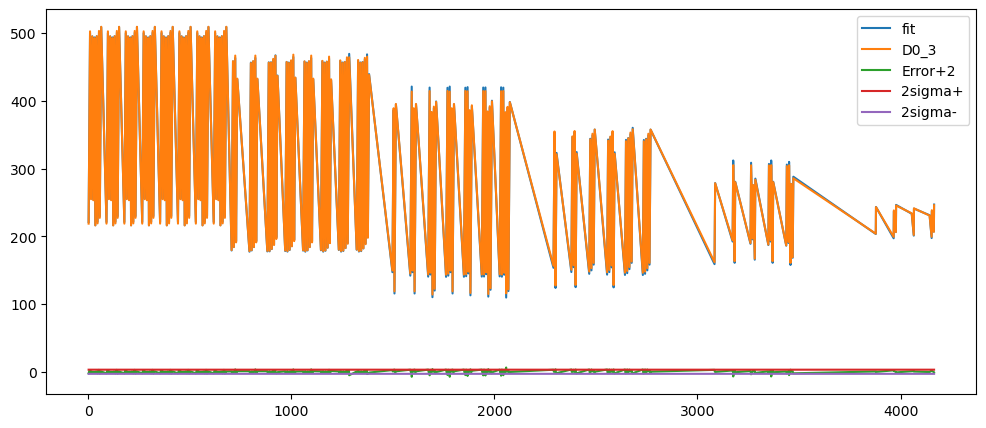

In [18]:
Data_Fit(df5[['D0_3','N','Qт','Ps']].dropna())

In [19]:
df5_=df5.dropna()
df5_[['D0_3','N','Gd','Qт']]

,D0_3,N,Gd,Qт
2,218.680142,40,1000,0
3,259.666471,50,1000,0
4,300.565392,60,1000,0
5,341.686274,70,1000,0
6,382.338004,80,1000,0
...,...,...,...,...
4143,230.627293,90,4500,150
4153,199.326106,80,4500,150
4154,238.455696,90,4500,150
4164,206.568681,80,4500,150


In [20]:
df5_['N2']=df5_['N']*df5_['N']
df5_['NQт']=df5_['N']*df5_['Qт']
df5_['Qт2']=df5_['Qт']*df5_['Qт']

C:\Users\User\AppData\Local\Temp\ipykernel_13664\2770540422.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_13664\2770540422.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_13664\2770540422.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [21]:
df5_

,Gd,Qт,Tr,dT,N,Td_i,T_s,Ps,q,Q0,D0_1,i_pv_1,D0_2,i_pv_2,D0_3,N2,NQт,Qт2
2,1000,0,40,2.6,40,40.000000,42.600000,1.475930,3380.181369,135.207255,225.345425,203.209155,219.210865,201.712242,218.680142,1600,0,0
3,1000,0,40,2.6,50,40.000000,42.600000,1.475930,3162.077858,158.103893,263.506488,211.880308,259.988116,211.127040,259.666471,2500,0,0
4,1000,0,40,2.6,60,40.000000,42.600000,1.475930,3009.409019,180.564541,300.940902,219.313825,300.597132,219.250394,300.565392,3600,0,0
5,1000,0,40,2.6,70,40.000000,42.600000,1.475930,2898.702836,202.909199,338.181998,225.654957,341.399665,226.153498,341.686274,4900,0,0
6,1000,0,40,2.6,80,40.000000,42.600000,1.475930,2811.417674,224.913414,374.855690,230.872109,381.773495,231.741937,382.338004,6400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,4500,150,40,2.6,90,73.333333,75.933333,1.369902,1577.005472,141.930492,236.550821,205.869779,231.108139,204.589349,230.627293,8100,13500,22500
4153,4500,150,50,2.6,80,83.333333,85.933333,1.564739,1552.705735,124.216459,207.027431,198.654740,199.915356,196.817914,199.326106,6400,12000,22500
4154,4500,150,50,2.6,90,83.333333,85.933333,1.564739,1625.697716,146.312794,243.854657,207.552776,238.898616,206.415183,238.455696,8100,13500,22500
4164,4500,150,60,2.6,80,93.333333,95.933333,1.864181,1604.307019,128.344561,213.907602,200.395187,207.139387,198.683348,206.568681,6400,12000,22500


In [22]:
df5_[['D0_3','N','N2','Qт','Ps','NQт','Qт2']]

,D0_3,N,N2,Qт,Ps,NQт,Qт2
2,218.680142,40,1600,0,1.475930,0,0
3,259.666471,50,2500,0,1.475930,0,0
4,300.565392,60,3600,0,1.475930,0,0
5,341.686274,70,4900,0,1.475930,0,0
6,382.338004,80,6400,0,1.475930,0,0
...,...,...,...,...,...,...,...
4143,230.627293,90,8100,150,1.369902,13500,22500
4153,199.326106,80,6400,150,1.564739,12000,22500
4154,238.455696,90,8100,150,1.564739,13500,22500
4164,206.568681,80,6400,150,1.864181,12000,22500


Index(['D0_3', 'N', 'Qт', 'Ps'], dtype='object')
коеффициенты [ 3.9873995  -1.23913947 31.90338294]
intercept 14.37696272409147
сигма: 1.5304934854171854


C:\Users\User\AppData\Local\Temp\ipykernel_13664\4162425236.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_13664\4162425236.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_13664\4162425236.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

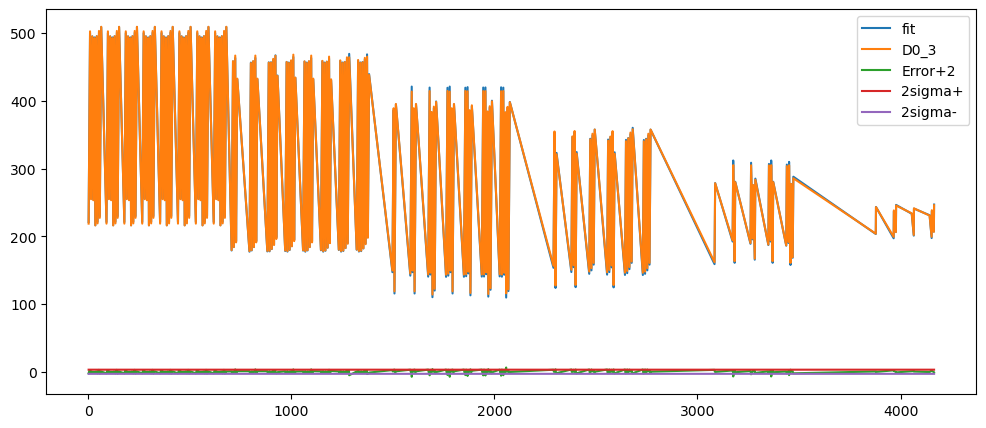

In [25]:
a=Data_Fit(df5_[['D0_3','N','Qт','Ps']])

Index(['D0_3', 'N', 'N2', 'Qт', 'Ps', 'NQт', 'Qт2'], dtype='object')
коеффициенты [ 3.99941013e+00  1.98534830e-04 -1.15154183e+00  3.14816021e+01
 -1.33206558e-03  1.51287651e-04]
intercept 12.905621359671045
сигма: 1.2391899389443186


C:\Users\User\AppData\Local\Temp\ipykernel_13664\4162425236.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_13664\4162425236.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_13664\4162425236.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

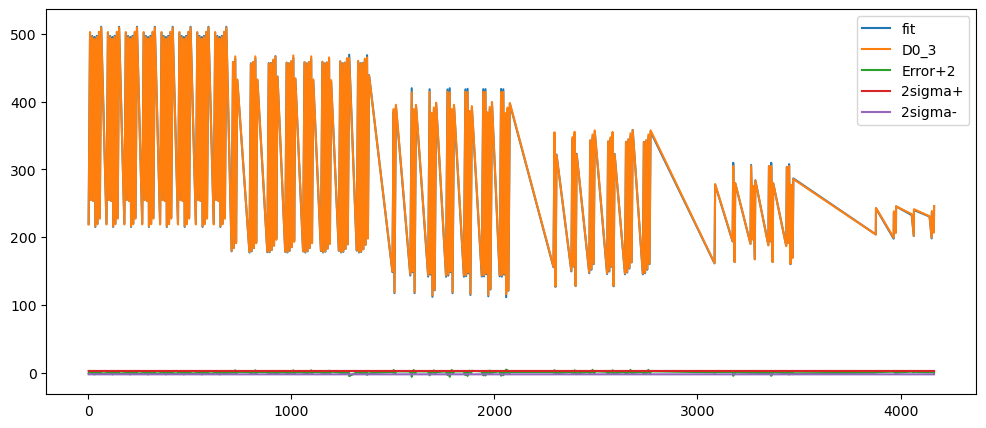

In [26]:
a=Data_Fit(df5_[['D0_3','N','N2','Qт','Ps','NQт','Qт2']])

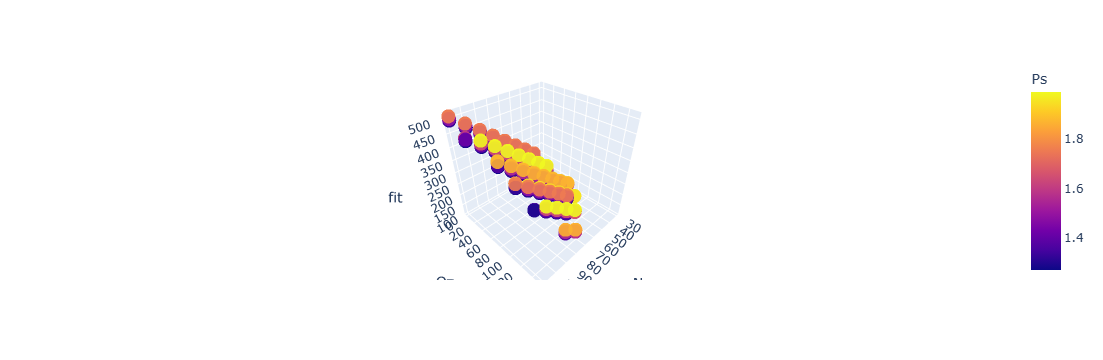

In [27]:
import plotly.express as px
Tdata2=a[1]
fig = px.scatter_3d(Tdata2, x='N', y='Qт', z='fit',
              color='Ps',opacity=0.9 )
fig.show()